In [47]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)
from kneed import KneeLocator

In [48]:
df=pd.read_csv('clean1.csv')

In [49]:
# Let's create a cbrn variable (no nuclear in the sample (un?)fortunately )
df['weapon.type_cbrn'] = df['weapon.type_chemical'] +  df['weapon.type_biological'] +  df['weapon.type_radiological']  

# Assuming 'df' is your DataFrame containing the dataset
# Selecting relevant variables including the target variable
data = df[['v2x_ex_military','v2x_clphy','v2x_rule','v2cldiscw','v2clacfree','nkill',
           'suicide', 
           'nperps', 
           'terrorist.org',
           'weapon.type_explosives', 
           'weapon.type_incendiary',
           'weapon.type_firearms',
           'weapon.type_cbrn',
           'weapon.type_melee',
           'weapon.type_sabotage.equipment',
           'weapon.type_vehicle..not.to.include.vehicle.borne.explosives..i.e...car.or.truck.bombs.',
           'weapon.type_fake.weapons',
           'attack.type_assassination',
           'attack.type_hostage.taking..kidnapping.',
           # 'attack.type_bombing.explosion',
           'attack.type_facility.infrastructure.attack',
           'attack.type_armed.assault',
           'attack.type_hijacking',
           # 'attack.type_unknown',
           'attack.type_unarmed.assault',
           'attack.type_hostage.taking..barricade.incident.',
           # 'target.type_private.citizens...property',
           'target.type_government..diplomatic.',
           'target.type_journalists...media',
           'target.type_police',
           'target.type_utilities',
           'target.type_military',
           'target.type_government..general.',
           'target.type_airports...aircraft',
           'target.type_business',
           'target.type_educational.institution',
           'target.type_violent.political.party',
           'target.type_religious.figures.institutions',
           # 'target.type_unknown',
           'target.type_transportation',
           'target.type_tourists',
           'target.type_ngo',
           'target.type_telecommunication',
           'target.type_food.or.water.supply',
           'target.type_terrorists.non.state.militia',
           'target.type_other',
           'target.type_maritime',
           'target.type_abortion.related'
          ]]

Elbow point at: 27


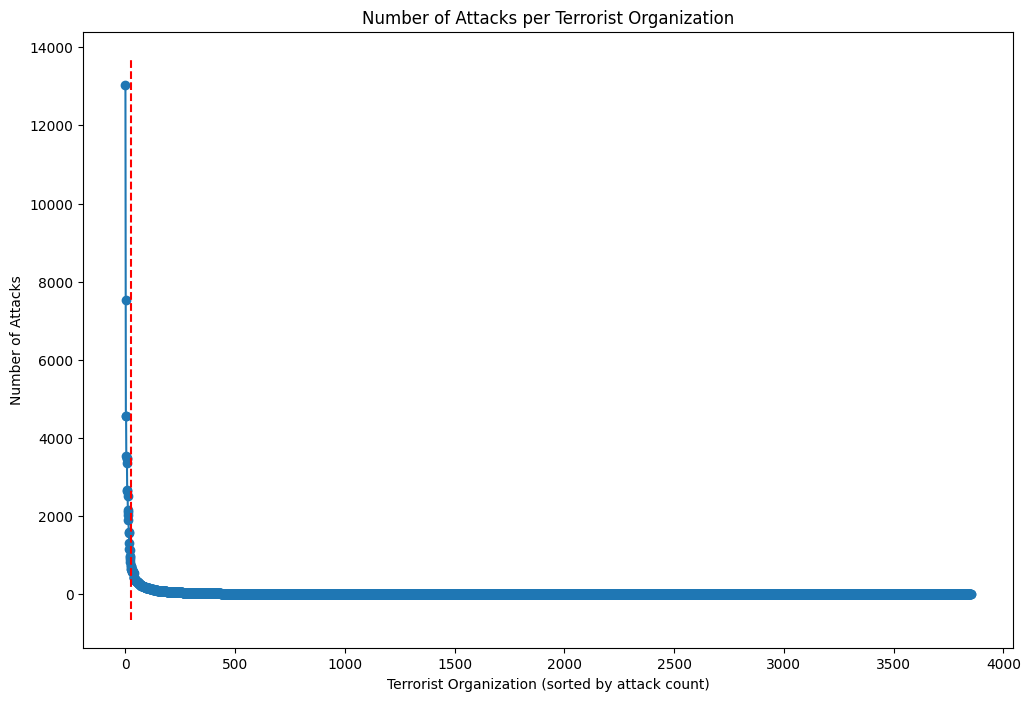

In [50]:
# Excluding 'Unknown'
df_filtered = df[df['terrorist.org'] != 'Unknown']

# Counting the number of attacks per organization
attacks_per_org = df_filtered['terrorist.org'].value_counts().sort_values(ascending=False)

# Converting to a format suitable for the Kneedle algorithm
# The Kneedle algorithm expects the data to be in a sorted order
x = range(1, len(attacks_per_org) + 1)
y = attacks_per_org.values

# Finding the elbow point
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

print(f"Elbow point at: {elbow_point}")

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='o', linestyle='-')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color = 'red')
plt.xlabel('Terrorist Organization (sorted by attack count)')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks per Terrorist Organization')

plt.show()

In [51]:
# identify the most common orgs
most_common_orgs = attacks_per_org.index.to_list()[:elbow_point]

# Modify the df['terrorist.org'] column
# Check if each value is in the most_common_orgs list, otherwise replace it with 'other'
df['terrorist.org'] = df['terrorist.org'].apply(lambda org: org if org in most_common_orgs else 'other')

In [52]:
X = df[['v2x_ex_military','v2x_clphy','v2x_rule','v2cldiscw','v2clacfree',
    'nkill',
    'suicide', 
    'nperps',
    'terrorist.org',
    'weapon.type_explosives', 
    'weapon.type_incendiary',
    'weapon.type_firearms',
    'weapon.type_cbrn',
    'weapon.type_melee',
    'weapon.type_sabotage.equipment',
    'weapon.type_vehicle..not.to.include.vehicle.borne.explosives..i.e...car.or.truck.bombs.',
    'weapon.type_fake.weapons',
    'attack.type_assassination',
    'attack.type_hostage.taking..kidnapping.',
    # 'attack.type_bombing.explosion', 
    'attack.type_facility.infrastructure.attack',
    'attack.type_armed.assault',
    'attack.type_hijacking',
    # 'attack.type_unknown',
    'attack.type_unarmed.assault',
    'attack.type_hostage.taking..barricade.incident.',
    # 'target.type_private.citizens...property',
    'target.type_government..diplomatic.',
    'target.type_journalists...media',
    'target.type_police',
    'target.type_utilities',
    'target.type_military',
    'target.type_government..general.',
    'target.type_airports...aircraft',
    'target.type_business',
    'target.type_educational.institution',
    'target.type_violent.political.party',
    'target.type_religious.figures.institutions',
    # 'target.type_unknown',
    'target.type_transportation',
    'target.type_tourists',
    'target.type_ngo',
    'target.type_telecommunication',
    'target.type_food.or.water.supply',
    'target.type_terrorists.non.state.militia',
    'target.type_other',
    'target.type_maritime',
    'target.type_abortion.related']]

In [53]:
data_cleaned = X.dropna(axis=0, how='any')

In [54]:
y_cleaned = data_cleaned['nkill']
y_log_cleaned = np.log(data_cleaned['nkill']+1)
X_cleaned = data_cleaned.drop(columns=['nkill'])

In [55]:
X_encoded = pd.get_dummies(X_cleaned, columns=['terrorist.org'], drop_first=True).astype(int)

In [56]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

In [57]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [58]:
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [59]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

In [60]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

In [61]:
from statsmodels.api import GLM, Poisson

In [62]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

C:\Users\lucab\AppData\Local\Temp\ipykernel_12864\453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  nkill   No. Observations:                32190
Model:                            GLM   Df Residuals:                    32122
Model Family:                 Poisson   Df Model:                           67
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5537e+05
Date:                Fri, 15 Mar 2024   Deviance:                   2.5288e+05
Time:                        18:50:36   Pearson chi2:                 8.95e+05
No. Iterations:                    16   Pseudo R-squ. (CS):             0.9700
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

In [63]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

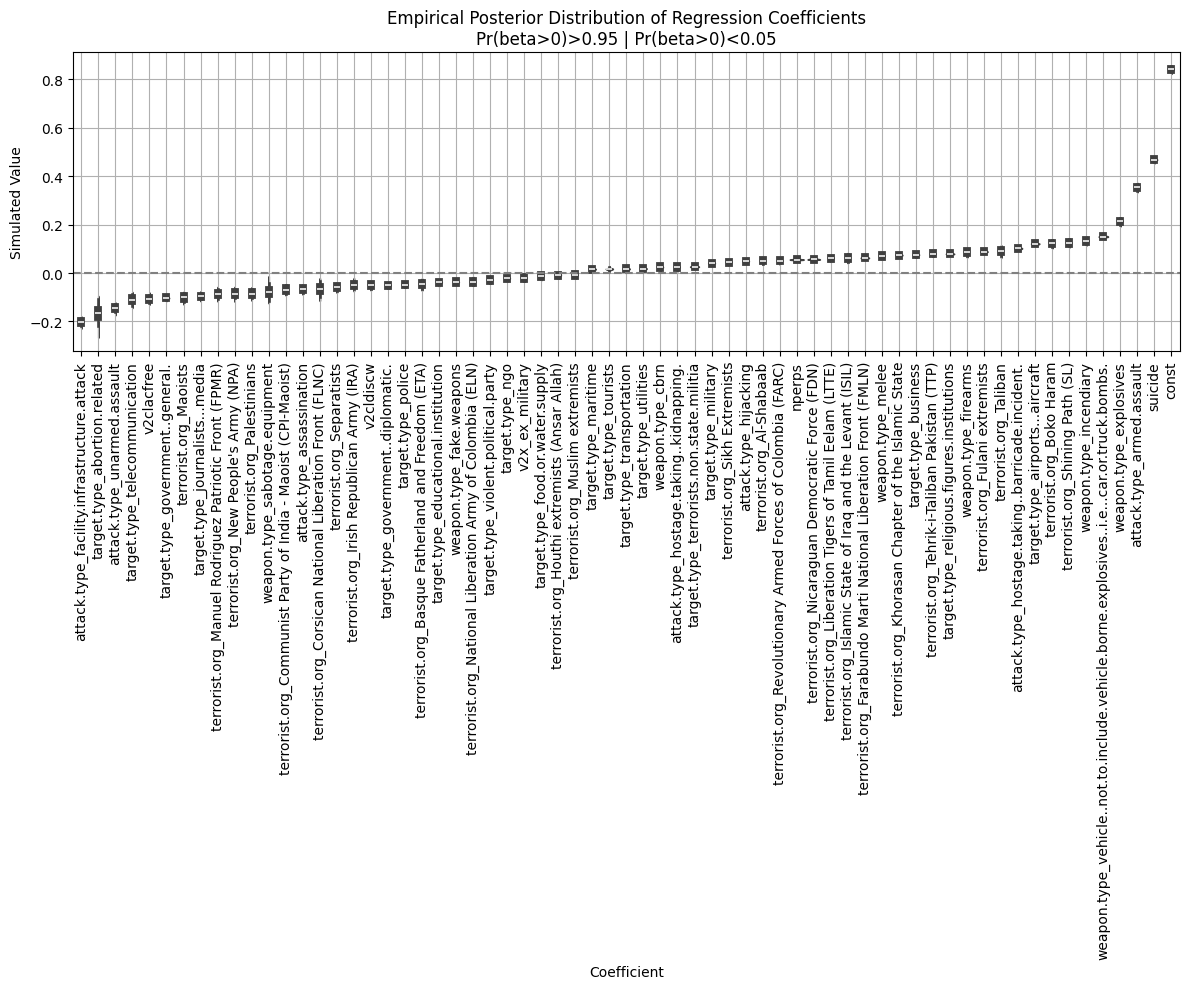

In [64]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [65]:
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [66]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [67]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

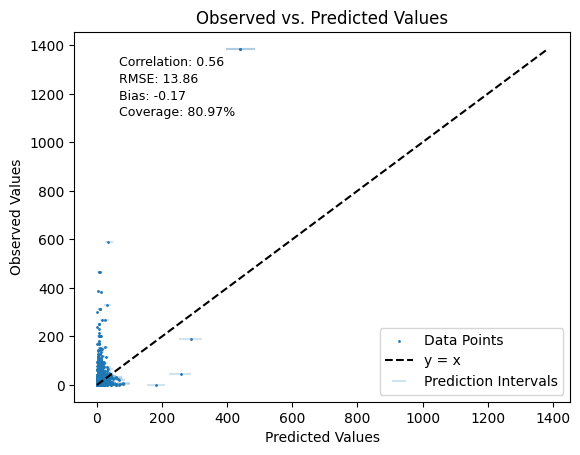

In [68]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()